In [106]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [117]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), 
    index_col="Date", 
    parse_dates=True,
    infer_datetime_format=True
    )

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [124]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc['January 1, 1990':, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

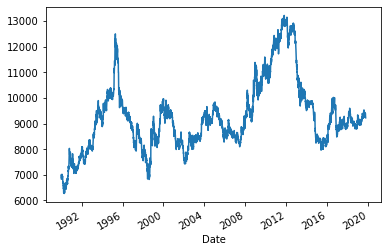

In [125]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [126]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!

yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures.Settle)

In [127]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
yen_settle = pd.DataFrame({'settle': yen_futures.Settle, 'noise': yen_noise, 'trend': yen_trend})

yen_settle.head()

,settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


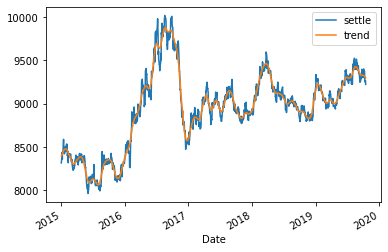

In [128]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!

yen_settle.settle.loc['2015':].plot(legend=True)
yen_settle.trend.loc['2015':].plot(legend=True)

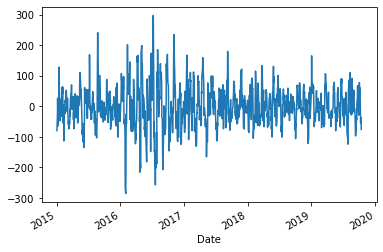

In [131]:
# Plot the Settle Noise
# YOUR CODE HERE!

yen_settle.noise.loc['2015':].plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [152]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [133]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

model = ARMA(returns, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!

results = model.fit()

C:\Users\stew1\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [134]:
# Output model summary results:
# YOUR CODE HERE!

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Fri, 20 Nov 2020   AIC                          15798.142
Time:                        21:30:50   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3346           +0.0000j            3.3346            0.5000
AR.2         -157.1656           +0.0000j          157.1656            0.5000
MA.1           -3.3935           +0.0000j            3.3935            0.5000
-----------------------------------------------------------------------------
"""

None of the p-values are below 0.01, or even 0.05.  Additionally, the AIC and BIC are quite large. These factors point to this model being a poor model.

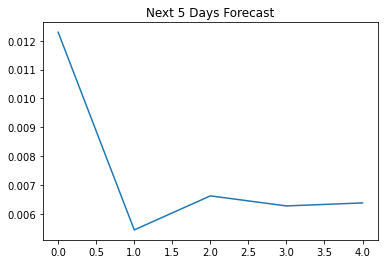

In [135]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!

returns = pd.DataFrame(results.forecast(steps=5)[0]).plot(title='Next 5 Days Forecast', legend=False)

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [136]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model = ARIMA(yen_futures.Settle, order=(5, 1, 1))

# Fit the model
# YOUR CODE HERE!
results = model.fit()

C:\Users\stew1\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\stew1\AppData\Local\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [137]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Fri, 20 Nov 2020   AIC                          83905.238
Time:                        21:31:01   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2823      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8919           -1.3785j            2.3409           -0.1002
AR.2            1.8919           +1.3785j            2.3409            0.1002
AR.3           -2.2708           -3.0202j            3.7786           -0.3526
AR.4           -2.2708           +3.0202j            3.7786            0.3526
AR.5          -11.0944           -0.0000j           11.0944           -0.5000
MA.1            3.3630           +0.0000j            3.3630            0.0000
-----------------------------------------------------------------------------
"""

Again, the P-values are all above 0.05 and the AIC and BIC are very large, which means this a poor model.


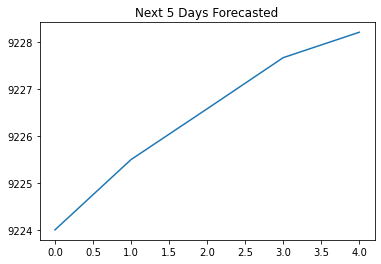

In [138]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!

pd.DataFrame(results.forecast(steps=5)[0]).plot(title='Next 5 Days Forecasted', legend=False)

Over the next 5 days, it looks like the Yen will strengthen against the USD.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [143]:
from arch import arch_model

In [153]:
# Estimate a GARCH model:
# YOUR CODE HERE!
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()

model = arch_model(returns, mean='Zero', vol='Garch', p=1, q=1)

# Fit the model
# YOUR CODE HERE!
res = model.fit(disp='off')

In [154]:
# Summarize the model results
# YOUR CODE HERE!

res.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Fri, Nov 20 2020   Df Residuals:                     7511
Time:                        21:44:31   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895

Now we're talking -- p-values are below 0.05 and 0.01 so this looks to be a reasonably good model.  AIC and BIC are still pretty high, so maybe there is some more tweaking we can do, but the p-values look good.

In [155]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [161]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)

In [162]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [163]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


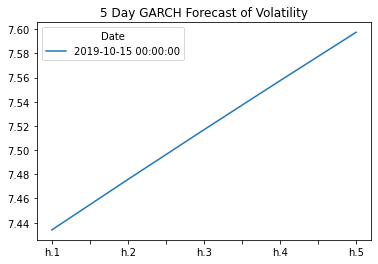

In [169]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title='5 Day GARCH Forecast of Volatility')

---

# Conclusions

### Based on your time series analysis, would you buy the yen now?
    * This is tough - on one hand, the ARMA model shows returns going down, but the ARIMA model shows the value going up.  Because neither of these models were "good" (both had p-values over 0.05), I do not think I would be purchasing the yen based on _these_ models.

### Is the risk of the yen expected to increase or decrease?
    *It sure looks like volatility is going up, which is your risk.  

### Based on the model evaluation, would you feel confident in using these models for trading?
    *I would not feel comfortable using these models for trading since they do not show statistically relevant forecasts.